# Introduction (what we’re building)

**Goal**: analyze long-term global surface temperature data from the “Climate Change: Earth Surface Temperature Data” Kaggle dataset, produce:

* clean, well-documented R analysis (global trends, seasonality, decadal averages, anomalies),

* statistical trend & change-point checks,

* country-level summaries,

* export cleaned tables ready to import into Power BI,

* a Power BI dashboard with interactive visuals (time series, heatmap, KPIs, map, filters).

# Prerequisites


* Kaggle account and the dataset added to your Notebook:https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data


* Use a Kaggle Notebook with R kernel.

* Basic familiarity with R and Power BI Desktop.

* Packages used in R: tidyverse, lubridate, ggplot2, plotly (optional), Kendall (trend test), changepoint (change point detection), zoo (rolling averages), scales.

***Start: Install & load packages***

In [6]:
# Install if needed (Kaggle usually has many packages, but include install guard)
pkgs <- c("tidyverse","lubridate","zoo","scales","plotly","Kendall","changepoint")
for(p in pkgs){
  if(!requireNamespace(p, quietly = TRUE)) install.packages(p, repos = "https://cloud.r-project.org")
}
# Load libraries
library(tidyverse)
library(lubridate)
library(zoo)
library(scales)
library(plotly)
library(Kendall)     # Mann-Kendall test
library(changepoint) # change point detection


***Import the main file***

In [7]:
# Path in Kaggle Notebook
path <- "../input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv"

gt <- read_csv(path, show_col_types = FALSE)

glimpse(gt)
summary(gt)

Rows: 3,192
Columns: 9
$ dt                                        <date> 1750-01-01, 1750-02-01, 175…
$ LandAverageTemperature                    <dbl> 3.034, 3.083, 5.626, 8.490, …
$ LandAverageTemperatureUncertainty         <dbl> 3.574, 3.702, 3.076, 2.451, …
$ LandMaxTemperature                        <dbl> NA, NA, NA, NA, NA, NA, NA, …
$ LandMaxTemperatureUncertainty             <dbl> NA, NA, NA, NA, NA, NA, NA, …
$ LandMinTemperature                        <dbl> NA, NA, NA, NA, NA, NA, NA, …
$ LandMinTemperatureUncertainty             <dbl> NA, NA, NA, NA, NA, NA, NA, …
$ LandAndOceanAverageTemperature            <dbl> NA, NA, NA, NA, NA, NA, NA, …
$ LandAndOceanAverageTemperatureUncertainty <dbl> NA, NA, NA, NA, NA, NA, NA, …


       dt             LandAverageTemperature LandAverageTemperatureUncertainty
 Min.   :1750-01-01   Min.   :-2.080         Min.   :0.0340                   
 1st Qu.:1816-06-23   1st Qu.: 4.312         1st Qu.:0.1867                   
 Median :1882-12-16   Median : 8.611         Median :0.3920                   
 Mean   :1882-12-15   Mean   : 8.375         Mean   :0.9385                   
 3rd Qu.:1949-06-08   3rd Qu.:12.548         3rd Qu.:1.4192                   
 Max.   :2015-12-01   Max.   :19.021         Max.   :7.8800                   
                      NA's   :12             NA's   :12                       
 LandMaxTemperature LandMaxTemperatureUncertainty LandMinTemperature
 Min.   : 5.90      Min.   :0.0440                Min.   :-5.407    
 1st Qu.:10.21      1st Qu.:0.1420                1st Qu.:-1.335    
 Median :14.76      Median :0.2520                Median : 2.950    
 Mean   :14.35      Mean   :0.4798                Mean   : 2.744    
 3rd Qu.:18.45      3rd

***Clean & basic transforms***

In [9]:
# Convert dt to Date, create Year & Month
gt <- gt %>%
  mutate(dt = as.Date(dt),
         Year = year(dt),
         Month = month(dt),
         MonthName = month(dt, label = TRUE, abbr = TRUE))

In [10]:
# Check missingness
sapply(gt, function(x) sum(is.na(x)))
# Remove exact duplicate rows (if any)
gt <- distinct(gt)

dt 
                                        0 
                   LandAverageTemperature 
                                       12 
        LandAverageTemperatureUncertainty 
                                       12 
                       LandMaxTemperature 
                                     1200 
            LandMaxTemperatureUncertainty 
                                     1200 
                       LandMinTemperature 
                                     1200 
            LandMinTemperatureUncertainty 
                                     1200 
           LandAndOceanAverageTemperature 
                                     1200 
LandAndOceanAverageTemperatureUncertainty 
                                     1200 
                                     Year 
                                        0 
                                    Month 
                                        0 
                                MonthName 
                                        0

In [11]:
# Keep relevant columns (others: LandAverageTemperatureUncertainty maybe)
gt <- gt %>% select(dt, Year, Month, MonthName, 
                    LandAverageTemperature, LandAverageTemperatureUncertainty,
                    LandMaxTemperature, LandMaxTemperatureUncertainty,
                    LandMinTemperature, LandMinTemperatureUncertainty,
                    LandAndOceanAverageTemperature) 

***Create baseline (1951–1980) & anomaly***

In [12]:
baseline <- gt %>%
  filter(Year >= 1951, Year <= 1980) %>%
  summarize(baseline_mean = mean(LandAverageTemperature, na.rm = TRUE)) %>%
  pull(baseline_mean)

baseline
# Attach anomaly column
gt <- gt %>%
  mutate(Anomaly = LandAverageTemperature - baseline)

[1] 8.657956

***Exploratory plots: time series + rolling average***

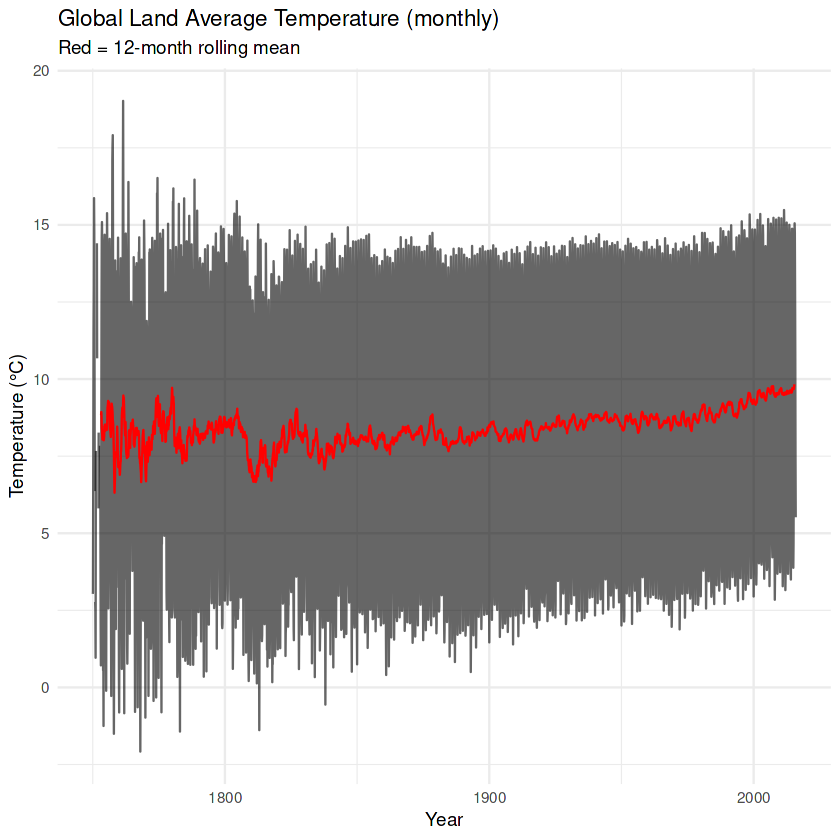

In [13]:
library(ggplot2)
# Full series (monthly)
p1 <- ggplot(gt, aes(x = dt, y = LandAverageTemperature)) +
  geom_line(alpha = 0.6) +
  geom_line(aes(y = rollmean(LandAverageTemperature, k = 12, fill = NA)), color = "red", na.rm = TRUE) +
  labs(title = "Global Land Average Temperature (monthly)",
       subtitle = "Red = 12-month rolling mean",
       x = "Year", y = "Temperature (°C)") +
  theme_minimal()
p1

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 12 rows containing non-finite outside the scale range
(`stat_smooth()`).”


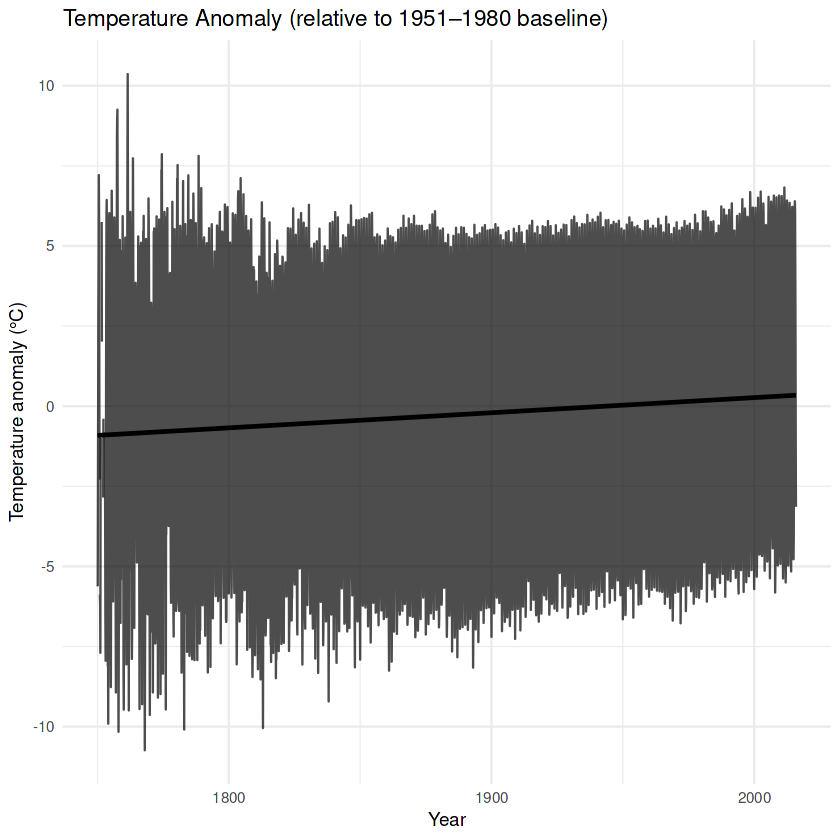

In [14]:
# Anomaly time series (relative to 1951-1980)
p2 <- ggplot(gt, aes(x = dt, y = Anomaly)) +
  geom_line(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE, color = "black") +
  labs(title = "Temperature Anomaly (relative to 1951–1980 baseline)",
       x = "Year", y = "Temperature anomaly (°C)") +
  theme_minimal()
p2

***Decadal averages & plotting***

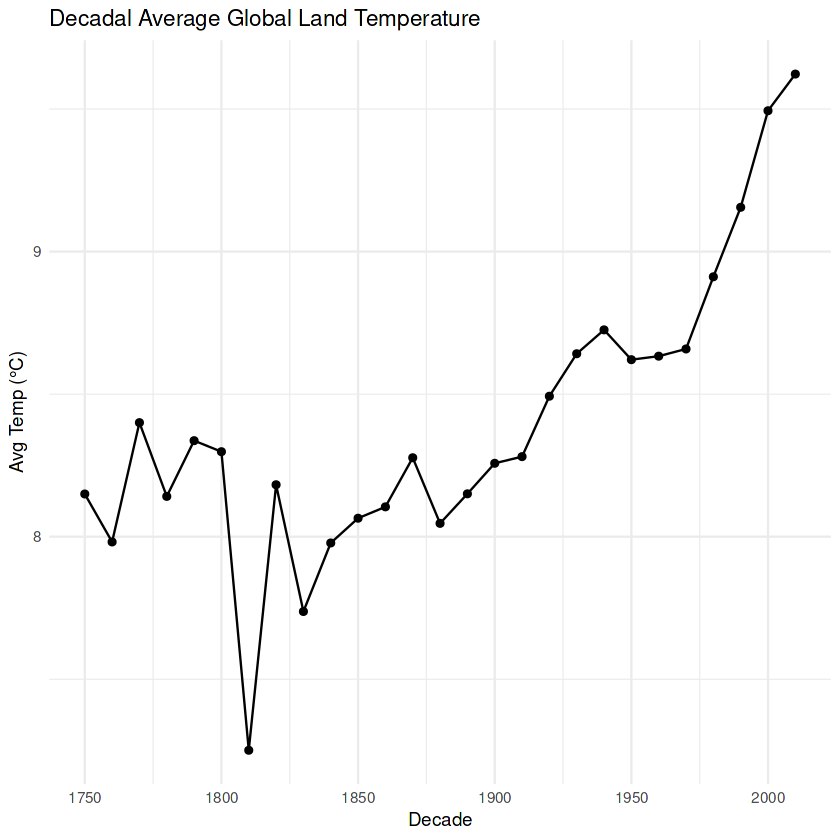

In [15]:
decadal <- gt %>%
  filter(!is.na(LandAverageTemperature)) %>%
  mutate(Decade = floor(Year/10)*10) %>%
  group_by(Decade) %>%
  summarize(AvgTemp = mean(LandAverageTemperature, na.rm = TRUE),
            AvgAnom = mean(Anomaly, na.rm = TRUE))

ggplot(decadal, aes(x = Decade, y = AvgTemp)) +
  geom_line(group = 1) + geom_point() +
  labs(title = "Decadal Average Global Land Temperature", x = "Decade", y = "Avg Temp (°C)") +
  theme_minimal()

***Seasonal/Monthly patterns***

`summarise()` has grouped output by 'Month'. You can override using the
`.groups` argument.


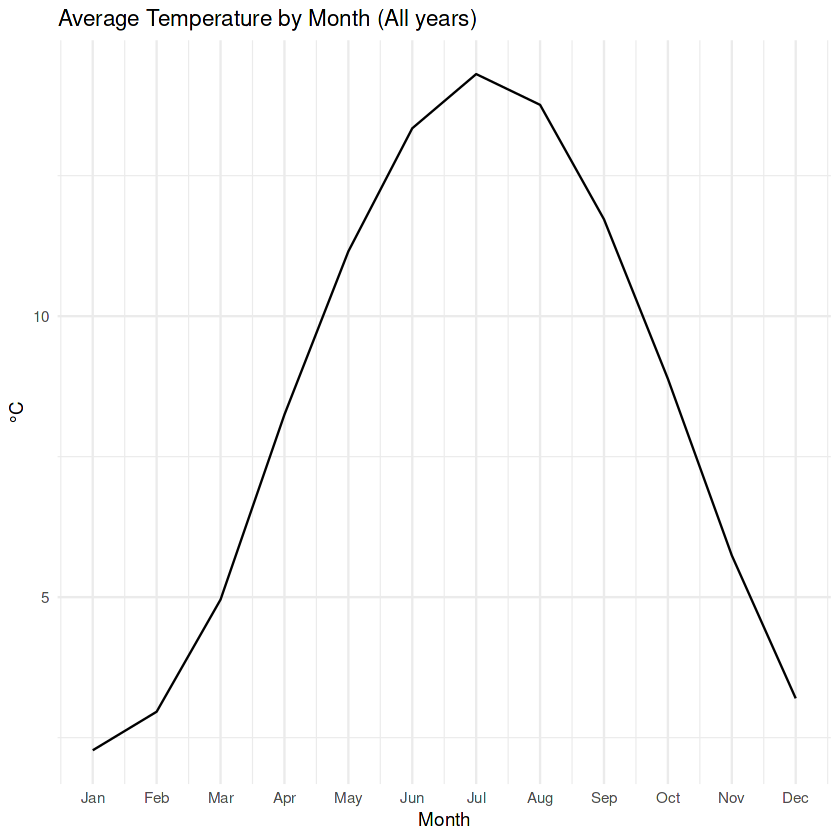

In [16]:
monthly_avg <- gt %>%
  group_by(Month, MonthName) %>%
  summarize(MeanTemp = mean(LandAverageTemperature, na.rm = TRUE)) %>%
  arrange(Month)

ggplot(monthly_avg, aes(x = Month, y = MeanTemp)) +
  geom_line(group = 1) +
  scale_x_continuous(breaks = 1:12, labels = month.abb) +
  labs(title = "Average Temperature by Month (All years)", x = "Month", y = "°C") +
  theme_minimal()

***Heatmap (Year × Month) — good for seasonality + long-term change***

`summarise()` has grouped output by 'Year'. You can override using the
`.groups` argument.


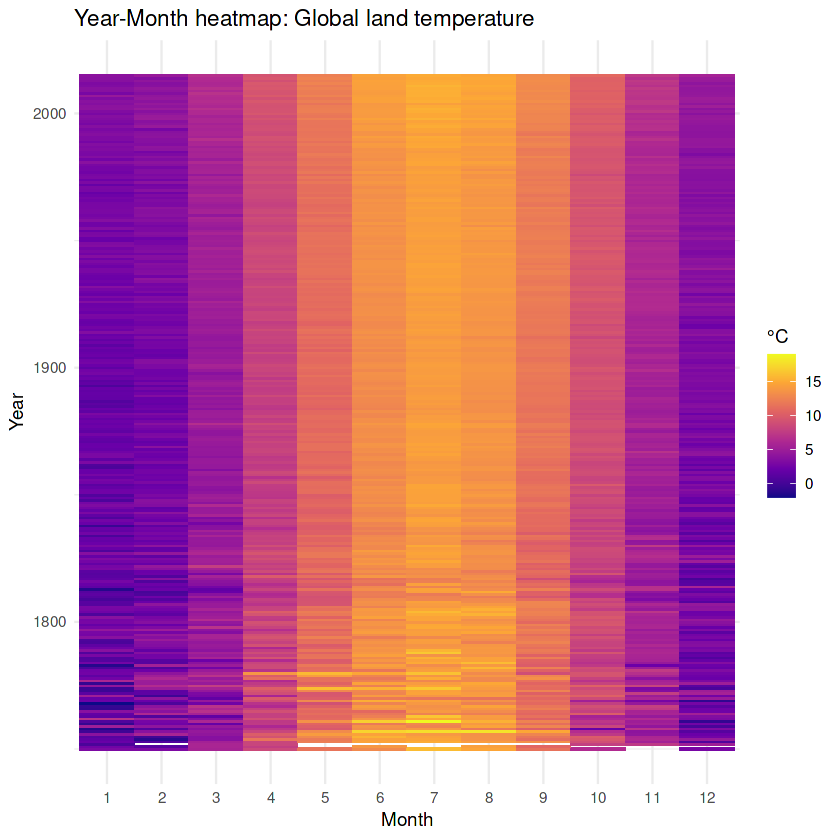

In [17]:
heat_data <- gt %>%
  filter(!is.na(LandAverageTemperature)) %>%
  mutate(Year = as.integer(Year), Month = factor(Month, levels = 1:12)) %>%
  group_by(Year, Month) %>%
  summarize(MeanTemp = mean(LandAverageTemperature, na.rm = TRUE)) %>%
  ungroup()

ggplot(heat_data, aes(x = Month, y = Year, fill = MeanTemp)) +
  geom_tile() +
  scale_fill_viridis_c(option = "plasma", na.value = "grey50") +
  labs(title = "Year-Month heatmap: Global land temperature", x = "Month", y = "Year", fill = "°C") +
  theme_minimal()


***Trend analysis: linear regression + slope per decade + R²***

In [18]:
# decimal year
gt_trend <- gt %>% filter(!is.na(Anomaly)) %>%
  mutate(dec_year = Year + (Month - 0.5)/12)

lm_fit <- lm(Anomaly ~ dec_year, data = gt_trend)
summary(lm_fit)

coef <- coef(lm_fit)
slope_per_year <- coef["dec_year"]
slope_per_decade <- slope_per_year * 10
r2 <- summary(lm_fit)$r.squared

list(slope_per_year = slope_per_year, slope_per_decade = slope_per_decade, r2 = r2)


Call:
lm(formula = Anomaly ~ dec_year, data = gt_trend)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.9102 -4.0950  0.1902  4.3149 11.2214 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -9.166422   1.908056  -4.804 1.63e-06 ***
dec_year     0.004716   0.001012   4.659 3.30e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.367 on 3178 degrees of freedom
Multiple R-squared:  0.006785,	Adjusted R-squared:  0.006473 
F-statistic: 21.71 on 1 and 3178 DF,  p-value: 3.301e-06


$slope_per_year
   dec_year 
0.004716339 

$slope_per_decade
  dec_year 
0.04716339 

$r2
[1] 0.006785186

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


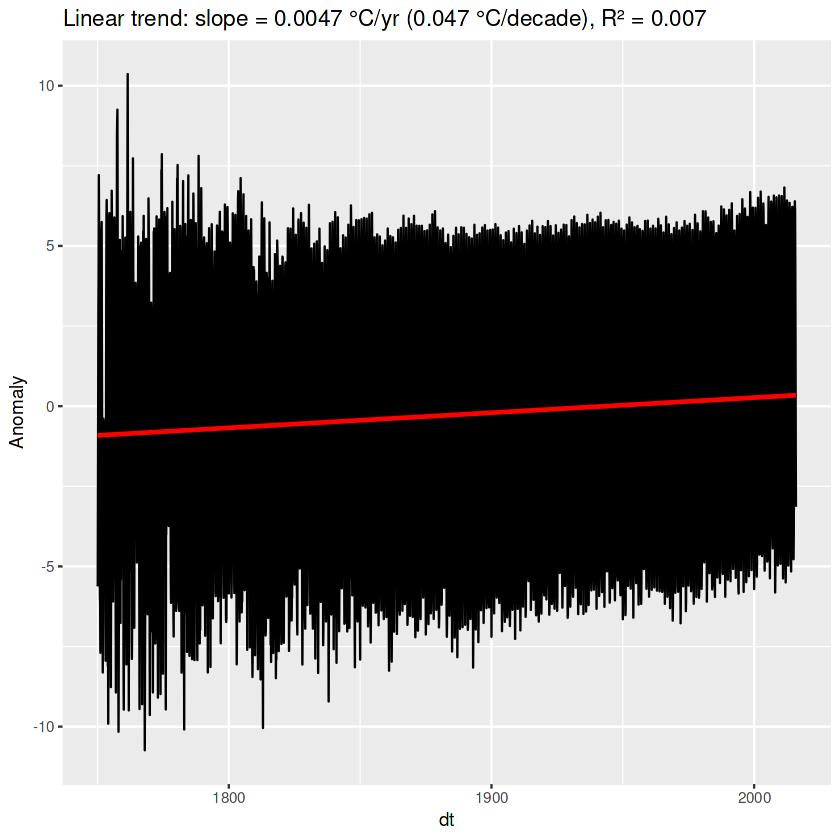

In [19]:
# Add fitted values for plotting
gt_trend <- gt_trend %>% mutate(fit = predict(lm_fit, newdata = gt_trend))
ggplot(gt_trend, aes(x = dt, y = Anomaly)) +
  geom_line() +
  geom_line(aes(y = fit), color = "red", size = 1) +
  labs(title = sprintf("Linear trend: slope = %.4f °C/yr (%.3f °C/decade), R² = %.3f",
                       slope_per_year, slope_per_decade, r2))

***Non-parametric trend test: Mann–Kendall***

In [21]:
# Mann-Kendall on annual means (reduce noise)
annual <- gt %>%
  group_by(Year) %>%
  summarize(AnnualAnom = mean(Anomaly, na.rm = TRUE)) %>%
  filter(!is.na(AnnualAnom))

MannKendall(annual$AnnualAnom) # Kendall's tau, p-value

tau = 0.482, 2-sided pvalue =< 2.22e-16

***Change-point detection (where mean changes)***

[1] 174

[1] 1923

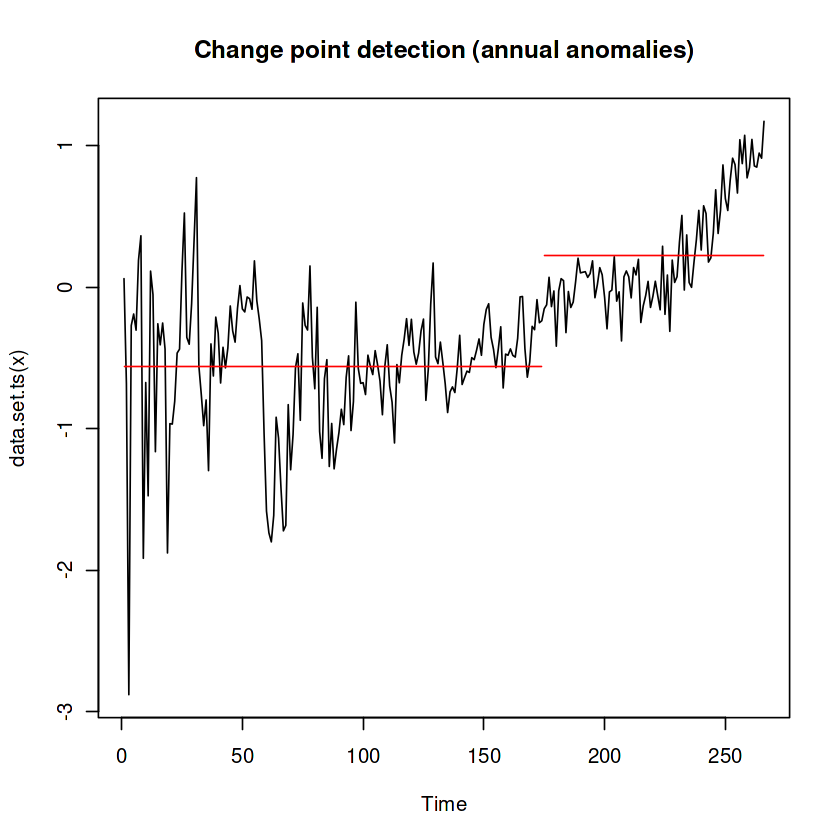

In [22]:
# Use annual average series for clarity
cpt <- cpt.mean(annual$AnnualAnom, method = "PELT", penalty = "BIC")
cpts(cpt)  # indices of change points
plot(cpt, main = "Change point detection (annual anomalies)")
# convert indices to years
change_years <- annual$Year[cpts(cpt)]
change_years

***Country-level analysis (example for a few countries)***

In [24]:
# Import country file
pc_path <- "../input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv"
countries <- read_csv(pc_path, show_col_types = FALSE) %>%
  mutate(dt = as.Date(dt), Year = year(dt), Month = month(dt)) %>%
  rename(Temp = AverageTemperature) %>%
  filter(!is.na(Temp))

`summarise()` has grouped output by 'Country'. You can override using the
`.groups` argument.


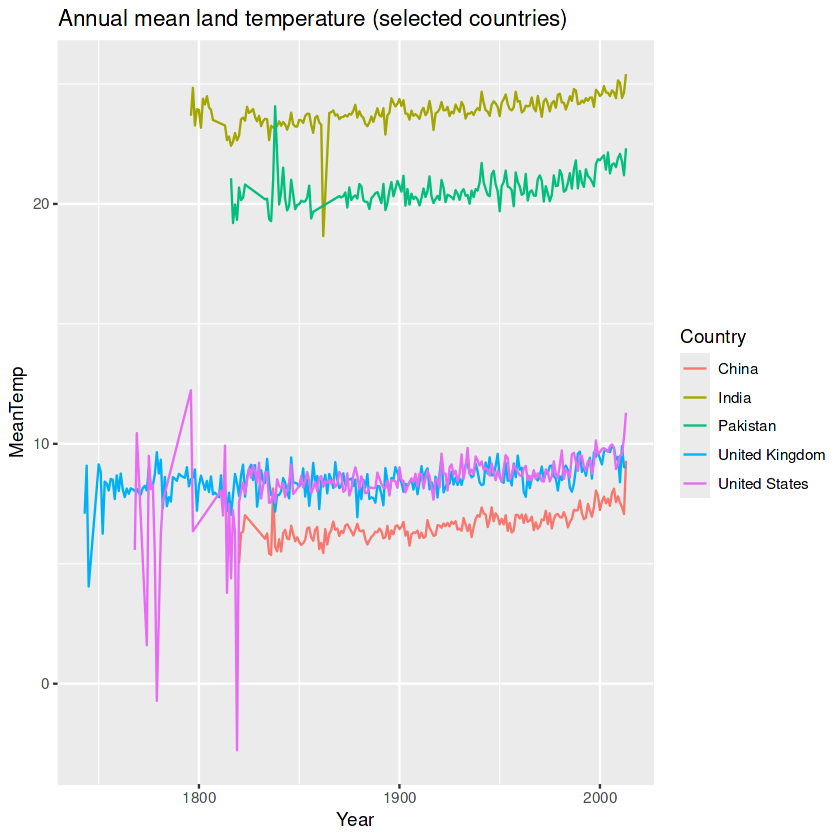

In [25]:
# Filter for sample countries (e.g., Pakistan, United States, India, China)
sel <- c("Pakistan","United States","India","China","United Kingdom")
country_sub <- countries %>%
  filter(Country %in% sel) %>%
  group_by(Country, Year) %>%
  summarize(MeanTemp = mean(Temp, na.rm = TRUE)) %>%
  drop_na()

ggplot(country_sub, aes(x = Year, y = MeanTemp, color = Country)) +
  geom_line() +
  labs(title = "Annual mean land temperature (selected countries)")

***Save processed tables for Power BI***

In [26]:
# Save cleaned monthly global & annual tables
library(readr)
write_csv(gt %>% select(dt, Year, Month, MonthName, LandAverageTemperature, Anomaly), "/kaggle/working/global_monthly_temp_clean.csv")
write_csv(annual %>% rename(Year=Year, AnnualAnomaly = AnnualAnom), "/kaggle/working/global_annual_anomaly.csv")
# Save country aggregated table
write_csv(country_sub, "/kaggle/working/country_yearly_temps_selected.csv")